# Algoritmos de Clasificación
En este apartado se va a ver el proceso de clasificación de texto utilizando técnicas de aprendizaje supervisado. Se utilizará un data set distinto al usado hasta el momento, que cuenta con los reportes de bugs de *Java Development Tools Bug* y que servirá para predecir la clasificación que se le dará a cada uno de estos reportes.

Como siempre, se comienza definiendo los ajustes que tendrá el notebook a lo largo de su ejecución:

In [2]:
import sys, os

#Carga del archivo setup.py
%run -i ../pyenv_settings/setup.py

#Imports y configuraciones de gráficas
%run "$BASE_DIR/pyenv_settings/settings.py"

%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'png'

# # to print output of all statements and not just the last
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# # otherwise text between $ signs will be interpreted as formula and printed in italic
pd.set_option('display.html.use_mathjax', False)

You are working on a local system.
Files will be searched relative to "..".


A continuación, se importarán la mayoría de bibliotecas y herramientas que se utilizarán a lo largo del notebook: 

In [3]:
import matplotlib.pyplot as plt
import html 
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
## Depracated:
# from sklearn.metrics import plot_confusion_matrix
## New version:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.dummy import DummyClassifier

Ahora se importará el Dataset que se utilizará para realizar la tarea. Este se ha descargado desde el repositorio de github https://github.com/logpai/bughub/blob/master/JDT/eclipse_jdt.csv y se ha incluido en la carpeta *data* del directorio del proyecto.

In [4]:
#Carga del archivo
file = "eclipse_jdt.csv"
file = f"{BASE_DIR}/data/eclipse_jdt.csv"

#Crear un Data Frame de pandas con este documento
df = pd.read_csv(file)

#Comprobación de que se ha procedido correctamente
print(df.columns)
df[['Issue_id','Priority','Component','Title','Description']].sample(2, random_state=42)

Index(['Issue_id', 'Priority', 'Component', 'Duplicated_issue', 'Title',
       'Description', 'Status', 'Resolution', 'Version', 'Created_time',
       'Resolved_time'],
      dtype='object')


,Issue_id,Priority,Component,Title,Description
38438,239715,P3,UI,No property tester for TestCaseElement for property projectNature,I20080613-2000; ; Not sure if this belongs to JDT/Debug or Platform/Debug.; ; I saw this error message several times today in my error log but Im not yet sure how to reproduce it.; ; -- Error Deta...
44129,395007,P3,UI,[package explorer] Refresh action not available on Java package folders,M3.; ; F5 (Refresh) is available as a context menu entry for ordinary source folders but not for Java package folders in the e4 Java Package explorer.; ; Please restore the 3.x functionality.


Se observa que el Data Frame cuenta con varias columnas correspondientes a distintos elementos o características que se deben indicar a la hora de reportar un bug para que sea más fácil para el desarrollador reproducir el error y así poder solucionarlo.

En este caso, únicamente se necesitarán las columnas *Priority*, *Component* y *Description*, pues lo que se va a tratar de hacer es clasificar, y en adelante predecir, los reportes en base a la prioridad.

## Entendiendo el Dataset
Antes de comenzar con el objeto del apartado, vamos a tratar de entender el Dataset y qué es lo que se desea con él. 

In [5]:
df.sample(1, random_state=325).T

,39288
Issue_id,261494
Priority,P3
Component,Text
Duplicated_issue,NaN
Title,[spell checking] Extra dictionaries dont appear in the UI.
Description,Created attachment 122930; This plugin adds some extra dictionaries but they dont appear in the UI.; ; Build ID: M20080911-1700; ; Steps To Reproduce:; 1. Run eclipse IDE with attached project whi...
Status,RESOLVED
Resolution,INVALID
Version,3.4.1
Created_time,2009-01-19 08:07:00 -0500


Como se indicó antes, nos vamos a centrar en las columnas Component, Priority y Description pues son las que realmente aportan información y datos necesarios para el entrenamiendo de un modelo de aprendizaje supervisado.

En la columna *Priority* se indica la prioridad que se le debería de dar al bug reportado. Esta va en una escala de P1 a P5, siendo P5 la máxima prioridad.

En *Component* se indica cuál es el componente de JVT en el cuál se ha originado el bug, en el caso anterior mostrado, se ha originado en *Text*.

En *Description* el usuario describe el bug de la forma más precisa posible.

Una vez explicado esto, si se muestra una gráfica con la distribución de prioridades que se le dan a los reportes del Dataset, se observa que la gran mayoría reciben un nivel de prioridad *P3*, eso porque es el nivel que se le asigna de forma predeterminada o porque en general los usuarios suelen dar un nivel medio la gran parte de las veces.

<Axes: xlabel='Priority'>

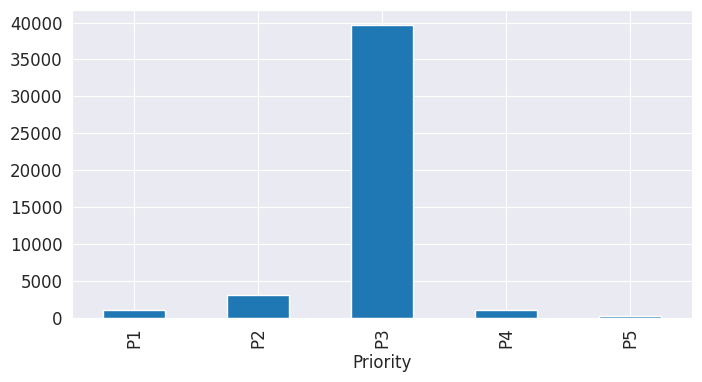

In [6]:
df['Priority'].value_counts().sort_index().plot(kind='bar')

Dle mismo modo, se puede mostrar el número de reportes asociados a cada tipo de componente.

In [7]:
df['Component'].value_counts()

Component
UI       17479
Core     13669
Debug     7542
Text      5901
APT        406
Doc        299
Name: count, dtype: int64

Una vez comprendida la estructura del Dataset, se procederá a crear el sistema de clasificación de texto.

## Construcción de un Clasificador de Texto
Un clasificador de texto se encuentra en la categoría de modelos de aprendizaje *supervisado*. Este tipo de algoritmos basan su funcionamiento en aprender las relaciones entre variables independientes y variables objetivo a través de datos etiquetados proporcionados.

En este caso, se ha escogido el método de clasificación para entrenar el modelo, que usará variables independientes como la descripción del bug para así predecir la prioridad o el componente que se le debe dar a un reporte.

### Proceso de trabajo de un modelo de aprendizaje supervisado
Se divide en dos fases: entrenamiento y predicción.

La fase de entrenamiento comienza con los datos de entrenamiento, que incluyen las observaciones que se aportan, en este caso las descripciones de los reportes de bugs, y las etiquetas asociadas, que sería lo que se desea predecir, la prioridad o componente en este caso.

En la fase de predicción, el modelo recibe un nuevo reporte en este caso, lo transforma al formato de documento que se ha utilizado durante la fase de entrenamiento y a partir de este, el modelo genera la predicción.

### Preparación de los datos
A partir de este momento, comenzará el proceso de creación de modelo y se irá documentando todo el proceso.

Como se ha visto en capitulos anteriores, es muy importante la limpieza, normalización y transformación de los datos para que estén dispuestos de forma adecuada para el análisis de estos por parte del modelo.

Como se va a usar un nuevo Dataset en el que las columnas que realmente necesitaremos serán *Priority*, *Title* y *Description* (se va a predecir la prioridad en este caso, no el componente que origina el bug), se comenzará eliminado las columnas innecesarias del datafrane y aquellas filas que contengan valores vaciós o nulos.

In [8]:
#Selección de las columnas deseadas
df = df[['Title','Description','Priority']]
#Elimina filas sin valores
df = df.dropna()
#Une en la columna text las columnas Title y Description
df['text'] = df['Title'] + ' ' + df['Description']
#Elimina las columnas title y description
df = df.drop(columns=['Title','Description'])
df.columns

Index(['Priority', 'text'], dtype='object')

Ahora se va a usar una función *clean* que eliminará los caracteres especiales del texto.

In [9]:
def clean(text):
    # convert html escapes like &amp; to characters.
    text = html.unescape(text) 
    # tags like <tab>
    text = re.sub(r'<[^<>]*>', ' ', text)
    # markdown URLs like [Some text](https://....)
    text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)', r'\1', text)
    # text or code in brackets like [0]
    text = re.sub(r'\[[^\[\]]*\]', ' ', text)
    # standalone sequences of specials, matches &# but not #cool
    text = re.sub(r'(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ', text)
    # standalone sequences of hyphens like --- or ==
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ', text)
    # sequences of white spaces
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

In [10]:
df['text'] = df['text'].apply(clean)

In [11]:
df = df[df['text'].str.len() > 50]
df.sample(2)

,Priority,text
12610,P3,Unused private types; methods or fields should recognize serialVersionUID. It is a standard practice to declare the serialVersionUID field as; private static final.; ; The current compiler option ...
36135,P3,API to access the shared AST of the active editor 3.3; ; as the story of listening to Java delta to get the latest AST isnt complete (some AST are missing when a normal reconcile comes in between)...


### División de los datos
En la fase de entrenamiento del modelo, toda la información se divide en dos porciones, la de entrenamiento y la de test.

Normalmente se dividen con una proporción 80-20, utilizando la de mayor tamaño para el entrenamiento.

Se utilizará la función *"train_test_split"* de scikit-learn para realizar la división de las porciones. Esta función cuenta con varios parámetros que pueden adoptar distintos valores.

*test_size*: indica el porcentaje del total que se asignará a la porción de test.
*random_state*: número que indica cómo se mostrarán las columnas, y por lo tanto, cuáles irán a una porción u a otra.
*stratify*: este parámetro asegura que la distribución de variables objetivo se mantiene entre ambas porciones. En caso de no indicarse, la porción de entrenamiento podría tener un mayor número de observaciones de una clase respecto a la otra porción.

In [12]:
#Se indica el tamaño de la porción de test como 0.2 (20%)
X_train, X_test, Y_train, Y_test = train_test_split(df['text'],
                                                    df['Priority'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=df['Priority'])

print('Size of Training Data ', X_train.shape[0])
print('Size of Test Data ', X_test.shape[0])

Size of Training Data  36040
Size of Test Data  9011


### Entrenamiento del modelo de Machine Learning
Se entrenará al modelo de aprendizaje supervisado con un algoritmo que se adapte a las necesidades del objetivo que se desea obtener, en este caso, SVM es un algoritmo que será de gran ayuda, siendo de los más utilizados a la hora de trabajar con clasificación de texto.

#### Algoritmo Support Vector Machine (SVM)
Partiendo de un plano de dos dimensiones en el que están indicados distintos puntos, pertenecientes a dos clases, este algoritmo se encarga de elegir una línea que separe lo máximo posible los puntos de amblas clases que se encuentran más cercanos el uno del otro (support vectors). Obviamente, se pueden dar casos en los que haya puntos de una clase entre los puntos de la otra clase, pero SVM tiene en cuenta todo este tipo de variables y cuenta con un rango de tolerancia que acepta errores de este tipo como puntos clasificados erróneamente, lo que le permite definir la línea de todos modos. 

Antes de ejecutar el algoritmo, se deben tratar los datos para que estén en un formato apto para el uso de estos por parte de SVM, es decir, en este caso se debe representar el texto de la información en un formato numérico.

Se utilizará la *vectorización TF/IDF* vista en el capítulo anterior para conseguir la reprensetación correcta de los datos.

In [13]:
#Vectorización de la porción de entrenamiento
tfidf = TfidfVectorizer(min_df = 10, ngram_range=(1,2), stop_words="english")
X_train_tf = tfidf.fit_transform(X_train)

Para el modelo se utilizará el módulo *LinearSVC* de scikit-learn con una tolerancia de 0.00001.

In [14]:
model1 = LinearSVC(random_state=0, tol=1e-5)
model1.fit(X_train_tf, Y_train)

LinearSVC(random_state=0, tol=1e-05)

### Evaluación del modelo
Una vez obtenido el modelo, se debe evaluar el rendimiento del mismo para así decidir si es apto para realizar las tareas de predicción o se deben realizar cambios en los parámetros del mismo durante la fase de entrenamiento.

La forma más sencilla de evaluar el modelo es mediante la *precisión*: comparando el número de predicciones correctas con el número total de observaciones. Para medir la precisión, se utiliza el modelo entrenado para generar predicciones que se compararán con los valores reales.

*Generación de predicciones*: se aplica la vectorización a la porción de test y luego se ejecuta la función *predict* del modelo. Una vez generadas las predicciones, se usa la función *accuracy_score* que compara los valores reales con los predichos por el modelo y arroja un resultado (porcentaje normalizado).

In [15]:
X_test_tf = tfidf.transform(X_test)

In [16]:
Y_pred = model1.predict(X_test_tf)

In [17]:
print ('Accuracy Score - ', accuracy_score(Y_test, Y_pred))

Accuracy Score -  0.8761513705471091


Se ha obtenido una precisión de 0.87 (87%) que indica un buen modelo.

De todos modos, siempre es buena idea comparar el rendimiento de un modelo con otros enfoques más simples.

Se va a comparar ahora el modelo con el módudo *DummyClassifier* que proporciona simples estrategias de predicción, como es por ejemplo la función *most_frequent* que siempre predice la clase con más frecuencia, o *stratified*, que genera predicciones respetando la distribución de datos del modelo.

In [18]:
clf = DummyClassifier(strategy='most_frequent', random_state=42)
clf.fit(X_train, Y_train)
Y_pred_baseline = clf.predict(X_test)

DummyClassifier(random_state=42, strategy='most_frequent')

In [19]:
print ('Accuracy Score - ', accuracy_score(Y_test, Y_pred_baseline))

Accuracy Score -  0.8769281988680502


Se observa que la precisión obtenida en este caso es igual o muy similar, entonces se puede llegar a la conclusión de que el modelo entrenado no aporta un mayor valor en comparación con una estrategia simple que siempre selecciona la clase con mayor frecuencia (P3).

Otro aspecto que se debe analizar es cómo de bien rinde el modelo en función de los diferentes niveles de *Priority*. Para esto se va a utilizar una *matriz de confusión* que compara los valores predichos con los reales para todas las observaciones clasificadas.

#### Precision and Recall
Usando la matriz de confusión se pueden utilizar dos métricas en este caso, la de Precision y la de Recall.

La métrica Precisión indica, a partir de las predicciones positivas, la proporción de las predicciones que realmente son positivas o cuánto de preciso es nuestro modelo prediciendo clases positivas.

Por otro lado, la métrica Recall indica la proporción de cuántos de los valores positivos reales son identificados como reales por el modelo. Un elevado Recall indica que el modelo es capaz de identificar como positivos la mayoría de los positivos reales.

Uniendo estas dos métricas nos encontramos con la métrica *F1 scrore* que construye una media armónica de ambas medidas y permitir al mismo tiempo medir la precisión del modelo.

In [20]:
#Se construye la matriz de confusión
Y_pred = model1.predict(X_test_tf)
confusion_matrix(Y_test, Y_pred)

array([[  19,    1,  199,    4,    0],
       [   6,   18,  576,    8,    0],
       [   8,   48, 7827,   19,    0],
       [   0,    5,  192,   31,    0],
       [   0,    0,   50,    0,    0]])

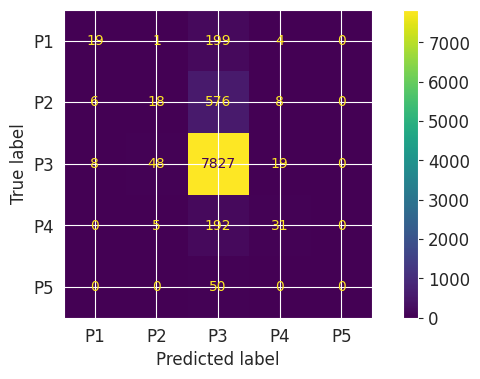

In [21]:
#Visualiación en un mapa de calor (mejor comprensión)
cm = confusion_matrix(Y_test, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = model1.classes_)

disp.plot()
plt.show()

Una forma aún más sencilla de determinar los resultados es usando la función *classification_report* que automáticamente calcula los valores vistos:

In [22]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

          P1       0.58      0.09      0.15       223
          P2       0.25      0.03      0.05       608
          P3       0.89      0.99      0.93      7902
          P4       0.50      0.14      0.21       228
          P5       0.00      0.00      0.00        50

    accuracy                           0.88      9011
   macro avg       0.44      0.25      0.27      9011
weighted avg       0.82      0.88      0.83      9011



Uno de los problemas que se ve a simple vista es que mientras los valores de la clase P3 son muy elevados, los de las otras clases son muy pequeños o incluso 0. 

Esto indica que el modelo no ha tenido un suficientemente buen proceso de aprendizaje y que sus predicciones son básicamente de la clase prioritaria (P3), dejando claro que durante la fase de evaluación se deben analizar métricas además de tener en cuenta únicamente los porcentajes de precisión del modelo.

### Desbalance entre clases
La razón por la que el modelo se comporta de este modo tiene que ver con el poco balance existente entre las distintas clases del dataset, que, como ya se vió al principio del capítulo, la gran mayoría de los reportes tienen un nivel de prioridad P3.

De todos modos, existen diversas tecnicas para tratar de subsanar estos problemas de desbalance entre clases.

En este punto se van a ver dos técnicas: *Upsampling* and *Downsampling*.

Upsampling es la técnica que consiste en aumentar el número de observaciones de las clases minoritarias artificialmente, por ejemplo, generando copias de estas observaciones con variaciones mínimas. 

Downsampling consiste en disminuir el número de observaciones de la clase mayoritaria. 

Veamos ahora qué ocurre si reducimos el número de observaciones de la clase P3 utilizando la técnica de downsampling.

In [23]:
#Filtrar los reportes con prioridad P3 y utilizar una muestra de 4000 filas de esta clase 
df_sampleP3 = df[df['Priority'] == 'P3'].sample(n=4000, random_state=123)

#Crear un dataframe adicional que incluye el resto de reportes de las demás clases 
df_sampleRest = df[df['Priority'] != 'P3']

#Concatenación de los dos dataframes para crear un nuevo dataset balanceado
df_balanced = pd.concat([df_sampleRest, df_sampleP3])

#Comprobar el estado de la clase desbalanceada (P3)
df_balanced['Priority'].value_counts()

Priority
P3    4000
P2    3038
P4    1138
P1    1117
P5     252
Name: count, dtype: int64

Ahora se observa que las clases cuentan con una cantidad de reportes más parejo, sin embargo esto lleva a una pérdida considerable de información, por lo tanto no se trata de la opción más recomendable.

Cuando se encuentra un problema de desbalance, se trata de evitarlo con estas técnicas explicadas, pero siempre conllevará una variación en la calidad de la información a tratar.

## Clasificador de texto con clases balanceadas
En este punto, habiendo creado el Dataframe con el desbalance de clases corregido, se volverá a realizar todo el proceso para crear y entrenar el modelo usando este Dataframe.

In [24]:
#Carga del Dataframe balanceado

df = df_balanced[['text', 'Priority']]
df = df.dropna()

#Preparación de los datos

df['text'] = df['text'].apply(clean)

#División en porciones de entrenamiento y test
X_train, X_test, Y_train, Y_test = train_test_split(df['text'],
                                                    df['Priority'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=df['Priority'])
print('Size of Training Data ', X_train.shape[0])
print('Size of Test Data ', X_test.shape[0])

#Entrenamiento del modelo de ML de aprendizaje supervisado

tfidf = TfidfVectorizer(min_df=10, ngram_range=(1, 2), stop_words="english")
X_train_tf = tfidf.fit_transform(X_train)

model1 = LinearSVC(random_state=0, tol=1e-5)
model1.fit(X_train_tf, Y_train)

#Evaluación del modelo

X_test_tf = tfidf.transform(X_test)
Y_pred = model1.predict(X_test_tf)
print('Accuracy Score - ', accuracy_score(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))

Size of Training Data  7636
Size of Test Data  1909


LinearSVC(random_state=0, tol=1e-05)

Accuracy Score -  0.5028810895756941
              precision    recall  f1-score   support

          P1       0.44      0.29      0.35       223
          P2       0.45      0.48      0.46       608
          P3       0.56      0.66      0.60       800
          P4       0.47      0.34      0.39       228
          P5       0.00      0.00      0.00        50

    accuracy                           0.50      1909
   macro avg       0.38      0.35      0.36      1909
weighted avg       0.48      0.50      0.49      1909



La precisión ahora es de un 50%, es decir, no es muy buena. En cualquier caso, los valores de *precision* y *recall* en las clases P1 y P2 han aumentado, por lo tanto el modelo es capaz de predecir mejor bugs de estas clases comparado con la capacidad que tenía anteriormente.

De todos modos, se puede afirmar que pese a que el modelo no es bueno, deja claro que no se debería usar para generar predicciones. Si se hubiese tomado en cuenta únicamente la precisión que tenía el modelo en la primera fase de entrenamiento, se hubiese creído que contaba con una gran precisión y era un buen modelo, lo que hubiese arrojado una cantidad elevada de predicciones erróneas que no tendrían ningún valor en último término.

In [25]:
clf = DummyClassifier(strategy='stratified', random_state=21)
clf.fit(X_train, Y_train)
Y_pred_baseline = clf.predict(X_test)
print ('Accuracy Score - ', accuracy_score(Y_test, Y_pred_baseline))

DummyClassifier(random_state=21, strategy='stratified')

Accuracy Score -  0.31691985332634887


Se pueden identificar y ver las partes en las que el modelo realiza unas predicciones precisas:

In [26]:
#Creación del DF que combina las columnas Title y Description
#Valores reales y predichos que se pueden comprobar
frame = { 'text': X_test, 'actual': Y_test, 'predicted': Y_pred }
result = pd.DataFrame(frame)

result[((result['actual'] == 'P1') | (result['actual'] == 'P2')) &
       (result['actual'] == result['predicted'])].sample(2, random_state=22)

,text,actual,predicted
8461,Variable view show old instance using build 20020917; ; Step to reproduce:; 1) create a selfhosting workspace (20020917).; 2) put a breakpoint in CompletionEngine at line 774 ; CompilationUnitDecl...,P1,P1
34854,model proxy created for Java debug target in var view While investigating bug 177910; I found that the deltas for thread creation were duplicated in the output produced by Walter. I discovered tha...,P2,P2


También cuando las predicciones no han sido buenas:

In [27]:
result[((result['actual'] == 'P1') | (result['actual'] == 'P2')) &
       (result['actual'] != result['predicted'])].sample(2, random_state=33)

,text,actual,predicted
40065,Too many semicolons after constructor completion I20090611-1540; ; public class Try {; Object m() {; return null;; }; }; ; select null; type new Runna; Ctrl+Space; press Enter to select the anonym...,P2,P3
7178,Next/Previous buttons have double image 20020606 XP; ; 1) Open Java editor; Outline; Search view; 2) Click in editor; click in outline; click in search; 3) Note that the show previous/ show next b...,P2,P3


Observando las predicciones, no se puede asegurar que exista una relación entre la descripción de un bug y su nivel de prioridad.

Para mejorar la precisión del modelo, es necesario realizar acciones adicionales de limpieza como se hizo con los datos utilizados en los capítulos anteriores.

## Uso de Validación cruzada (Cross-Validation) para estimar una precisión realista
*Cross validation* es una técnica capaz de entrenar y validar un modelo con distintas porciones de datos de forma repetitiva. De este modo, el modelo entrenado final contaría con un balance "correcto", que se encontraría entre los términos *underfitting* y *overfitting*.

Underfitting se origina cuando el modelo no es capaz de aprender las relaciones subyacentes de forma correctamente y genera unas predicciones similares para todas las observaciones que están muy lejos de ser las reales.

Overfitting ocurre cuando el modelo es demasiado complejo y ha comprendido los patrones subyacentes correctamente, pero genera unas desviaciones significantes en los datos de test.

En este caso se usará la variante *K-fold*. Esta consiste en dividir todos los datos de entrenamiento en K partes, el modelo se entrena por iteraciones, seleccionando en cada iteración una porción K de los datos para ese entrenamiento, y realizando la validación siempre con la porción k-ésima del conjunto.

In [28]:
#Vectorización
tfidf = TfidfVectorizer(min_df = 10, ngram_range=(1,2), stop_words="english")
df_tf = tfidf.fit_transform(df['text']).toarray()

#Cross-Validation con 5 folds (porciones)
scores = cross_val_score(estimator=model1,
                         X=df_tf,
                         y=df['Priority'],
                         cv=5)

print ("Validation scores from each iteration of the cross validation ", scores)
print ("Mean value across of validation scores ", scores.mean())
print ("Standard deviation of validation scores ", scores.std())

Validation scores from each iteration of the cross validation  [0.48192771 0.45311682 0.43949712 0.42221058 0.37297014]
Mean value across of validation scores  0.43394447354635934
Standard deviation of validation scores  0.036211476115013436


En la salida se observa la validación unitaria, media y desviación típica para cada iteración. Es importante realizar este paso y saber interpretarlo para poder identificar el verdadero potencial del modelo que se desea construir.

## Ajuste de hiperparámetros con Grid Search
*Grid Search* es una técnica que puede aumentar la precisión del modelo evaluando diferentes parámetros usados como argumentos por el modelo probando distintas combinaciones de hiperparámetros que puedan maximizar una métrica (precisión p.e.) del modelo de aprendizaje automático.

Sumado a esto, se puede utilizar un pipeline de preprocesamiento para probar diferentes valores del parámetros *n-gram_range* para la vectorización TF/IDF.

Todo esto combinado con la validación cruzada puede identificar el conjunto de parámetros que maximizarán la precisión del modelo a costa de un mayor consumo de CPU, memoria y tiempo de ejecución.

Primero se crea la pipeline de entrenamiento en la que se definen los pasos que se desean ejecutar, en este caso el vectorizador TF/IDF y el modelo de entrenamiento LinearSVC.

A continuación se define el set de parámetros que se desean probar en la variable *grid_param*. Como cada parámetro pertenece a una ejecución concreta del pipeline, se utilizará el nombre de cada paso como prefijo para cada parámetro.

Luego se utiliza la función *GridSearchCV* que proporciona la posibilidad de realizar varias ejecuciones con distintos parámetros como se explicó hace unos instantes, del que en base a los resultados obtenidos, se podrá elegir la versión con mejor rendimiento.

In [29]:
#Implementación del pipeline de entrenamiento
training_pipeline = Pipeline(
    steps=[('tfidf', TfidfVectorizer(
        stop_words="english")), ('model',
                                 LinearSVC(random_state=21, tol=1e-5))])

#Distintos parámetros que se utilizarán para realizar las pruebas
grid_param = [{
    'tfidf__min_df': [5, 10],
    'tfidf__ngram_range': [(1, 3), (1, 6)],
    'model__penalty': ['l2'],
    'model__loss': ['hinge'],
    'model__max_iter': [10000]
}, {
    'tfidf__min_df': [5, 10],
    'tfidf__ngram_range': [(1, 3), (1, 6)],
    'model__C': [1, 10],
    'model__tol': [1e-2, 1e-3]
}]

#Ejecución del pipeline con los distintos parámetros definidos
gridSearchProcessor = GridSearchCV(estimator=training_pipeline,
                                   param_grid=grid_param,
                                   cv=5)
gridSearchProcessor.fit(df['text'], df['Priority'])

#Muestra por pantalla los mejores parámetros obtenidos
best_params = gridSearchProcessor.best_params_
print("Best alpha parameter identified by grid search ", best_params)

#Muestra por pantalla el mejor resultado obtenido
best_result = gridSearchProcessor.best_score_
print("Best result identified by grid search ", best_result)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(stop_words='english')),
                                       ('model',
                                        LinearSVC(random_state=21,
                                                  tol=1e-05))]),
             param_grid=[{'model__loss': ['hinge'], 'model__max_iter': [10000],
                          'model__penalty': ['l2'], 'tfidf__min_df': [5, 10],
                          'tfidf__ngram_range': [(1, 3), (1, 6)]},
                         {'model__C': [1, 10], 'model__tol': [0.01, 0.001],
                          'tfidf__min_df': [5, 10],
                          'tfidf__ngram_range': [(1, 3), (1, 6)]}])

Best alpha parameter identified by grid search  {'model__loss': 'hinge', 'model__max_iter': 10000, 'model__penalty': 'l2', 'tfidf__min_df': 10, 'tfidf__ngram_range': (1, 3)}
Best result identified by grid search  0.4597171293871137


También se puede comprobar el rendimiento del resto de modelos generados para cómo interaccionan los valores de los distintos parámetros probados. 

In [30]:
#Top 5 mejores modelos y sus correspondientes parámetros
gridsearch_results = pd.DataFrame(gridSearchProcessor.cv_results_)
gridsearch_results[['rank_test_score', 'mean_test_score',
                    'params']].sort_values(by=['rank_test_score'])[:5]

,rank_test_score,mean_test_score,params
2,1,0.46,"{'model__loss': 'hinge', 'model__max_iter': 10000, 'model__penalty': 'l2', 'tfidf__min_df': 10, 'tfidf__ngram_range': (1, 3)}"
0,2,0.46,"{'model__loss': 'hinge', 'model__max_iter': 10000, 'model__penalty': 'l2', 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 3)}"
1,3,0.46,"{'model__loss': 'hinge', 'model__max_iter': 10000, 'model__penalty': 'l2', 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 6)}"
3,4,0.46,"{'model__loss': 'hinge', 'model__max_iter': 10000, 'model__penalty': 'l2', 'tfidf__min_df': 10, 'tfidf__ngram_range': (1, 6)}"
4,5,0.44,"{'model__C': 1, 'model__tol': 0.01, 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 3)}"
